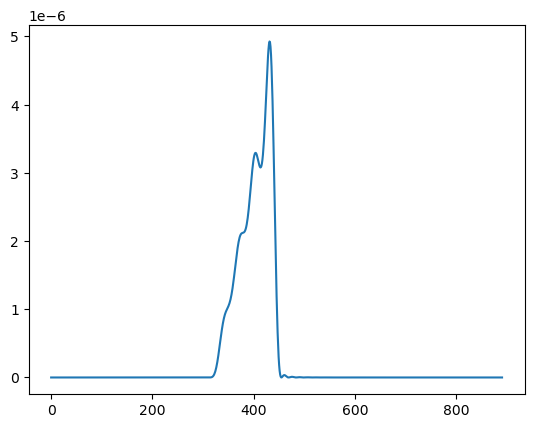

In [1]:
import numpy as np
import matplotlib.pyplot as plt

norm_rel_negative = np.load('norm_rel_negative.npy')
plt.plot(norm_rel_negative)

In [16]:
shift_roll = 0.75 * np.roll(norm_rel_negative, 1000)
overlap = np.sum(norm_rel_negative * shift_roll)
print(overlap)

1.137475974218551e-11


In [18]:
# 2023-06-16
# 1 修改目标函数：
#   1.1 以 远场 (-25, 0) 负角度 为目标函数，设置为目标函数最大
# 2. 以垂直耦合eps开始
# 3. 迭代次数设置 200
# 4. 未添加结构对称

import os
import sys

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import signal, special
import math
import meep as mp
import nlopt  # need install nlopt

######################## Basic simulation ############################
np.random.seed(1000)
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

# length parameter
input_wvg_length = 5
output_wvg_length = 5
# design_region
design_region_x = 15
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

# height parameter
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

# geometry
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length + dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length - dpml,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

# design region
minimum_length = 0.05  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

design_region_resolution_x = int(resolution)
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
# 结构对称
# design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_MEAN")
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)

# Sources
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h),
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)

# Simulation
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

######################## Basic simulation ############################

######################## Opt settings ############################

# near_field_region
d_angle = 0.2  # !angle resolution
ff_distance = 1e6  # far field distance
ff_angle = 89  # !far field angle range
ff_number = int(2 / d_angle * ff_angle) + 1  # !far field number
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)  # far field angle list
ff_points = [
    mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]  # far field points list

# !起始和结束优化的角度
start_angle = 0
stop_angle = 25

# near field region
NearRegion = [
    mp.Near2FarRegion(
        center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=+1,
    )
]

# !归一化效率
# efficiency = 0.76

# oblist
ob_list = [mpa.Near2FarFields(sim, NearRegion, [ff_point]) for ff_point in ff_points]
# !目标远场强度分布
final_intensity = np.load("norm_rel_negative.npy")


# 对比每一个角度下的电场强度与目标电场强度的差值
#! return scalar obj not vector
def J3(*FF):
    obj = 0
    points = []
    # 将FF中每一个的点的Ez值取出来存入points中
    # FF [list] FF[0][0, 0, 2] = point[0, 0, 2]
    # point.size -> [1, 1, 6] -> ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
    for point in FF:
        points.append(point[0, 0, 2])
    return npa.sum((npa.abs(points) ** 2) * final_intensity)


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J3],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    decay_by=1e-5,
)

# define the initial design and confirm the optimization problem
number_para = Nx * Ny

# 初始化granting coupler为上一次优化的结果
# 将 [1.44-1.96] 的 eps 映射到 [0, 1] 之间
init_para = (
    np.abs(np.load("final_eps_vertical_15.npy")[0:number_para, 5]) - 1.44**2
) / (1.96**2 - 1.44**2)

init_para[init_para < 0] = 0
init_para[init_para > 1] = 1
opt.update_design([init_para[0:number_para]])

# # 随机初始化
# init_para = np.random.random(number_para)
# opt.update_design([init_para[0:number_para]])

evaluation_history = []
cur_iter = [0]


# def mapping(x):
#     projected_field = (npa.flipud(x) + x) / 2  # left-right symmetry
#     # interpolate to actual materials
#     return projected_field.flatten()


def f(v, gradient):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([v])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = np.squeeze(dJ_du)

    evaluation_history.append(np.real(f0))

    print("Objective function: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


# def f(v, gradient):
#     print("Current iteration: {}".format(cur_iter[0] + 1))

#     f0, dJ_du = opt([mapping(v)])  # compute objective and gradient

#     if gradient.size > 0:
#         gradient[:] = np.squeeze(dJ_du)

#     evaluation_history.append(np.real(f0))

#     print("Objective function: {}".format(np.real(f0)))

#     cur_iter[0] = cur_iter[0] + 1

#     return np.real(f0)


algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
# x = np.random.random((n,)) * 0.5
x = init_para[0:number_para]

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))
# cur_beta = 4
# beta_scale = 2
# num_betas = 6
update_factor = 200
ftol = 1e-5
solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(lb)
solver.set_upper_bounds(ub)
solver.set_max_objective(lambda a, g: f(a, g))
solver.set_maxeval(update_factor)
# solver.set_ftol_rel(ftol)
x[:] = solver.optimize(x)

######################## Opt settings ############################

# save evalution_history and eps
np.save("eval_history_negative_1.npy", evaluation_history)

eps = opt.sim.get_array(
    component=mp.Dielectric,
    frequency=fcen,
    center=mp.Vector3(
        -0.5 * sx + dpml + input_wvg_length + 0.5 * design_region_x,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
        0,
    ),
    size=mp.Vector3(design_region_x, h, 0),
)
np.save("final_eps_negative_1.npy", eps)


Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.0014441 s
Working in 2D dimensions.
Computational cell is 27 x 6.2 x 0 with resolution 50
     block, center = (0,-1.85,0)
          size (27,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.6,0)
          size (27,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.75,0)
          size (27,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-10,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (10,0.5,0)
          size (5,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
         

MPB solved for frequency_1(1,0,0) = 0.607781 after 8 iters
MPB solved for frequency_1(2.12376,0,0) = 1.2419 after 8 iters
MPB solved for frequency_1(2.1834,0,0) = 1.27381 after 6 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 3 iters
MPB solved for frequency_1(2.18354,0,0) = 1.27389 after 1 iters
on time step 1106 (time=11.06), 0.00361679 s/step
on time step 2216 (time=22.16), 0.00360367 s/step
on time step 3344 (time=33.44), 0.00354773 s/step
on time step 4480 (time=44.8), 0.0035271 s/step
on time step 5610 (time=56.1), 0.00353993 s/step
on time step 6723 (time=67.23), 0.00359642 s/step
on time step 7843 (time=78.43), 0.00357293 s/step
on time step 8967 (time=89.67), 0.00356081 s/step
on time step 10089 (time=100.89), 0.00356549 s/step
on time step 11213 (time=112.13), 0.00355921 s/step
on time step 12350 (time=123.5), 0.00351928 s/step
on time step 13469 (time=134.69), 0.00357656 s/step
on time step 14583 (time=145.83), 0.00359092 s/step
on time step 15707 (time=157.07